# 5회차 실습 과제

## 문제 항목

| 문제     | 주제                                       | 핵심 학습 포인트                              |
|----------|--------------------------------------------|-----------------------------------------------|
| 문제 1   | 3개 공장의 배터리 수명 비교 (ANOVA)        | 가정 검정 → 검정 선택 → 사후검정 → 효과크기   |
| 문제 2   | 직원 데이터 상관분석                       | Pearson vs Spearman, 산점도, 상관 vs 인과      |
| 문제 3   | 앱 UI 변경 A/B 테스트 (전환율)             | 실험 설계 → 표본 크기 산정 → 검정 → 의사결정   |
| 문제 4   | 학습 앱 A/B 테스트 (연속형 지표)           | 연속형 A/B 테스트, CLT, 모수 vs 비모수         |

In [2]:
# 필수 라이브러리 Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
import pingouin as pg
import scikit_posthocs as sp
from statsmodels.stats.proportion import proportions_ztest, proportion_effectsize, proportion_confint, confint_proportions_2indep
from statsmodels.stats.power import NormalIndPower
from scipy.stats import skew
import seaborn as sns
import warnings
import platform

warnings.filterwarnings('ignore')

# 운영체제별 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False

print("=" * 60)
print("5회차 실습 과제")
print("=" * 60)

5회차 실습 과제


---

## 문제 1: 3개 공장의 배터리 수명 비교 (ANOVA)

전자제품 회사에서 3개 공장(A, B, C)에서 생산한 배터리의 수명(시간)이 동일한지 검증합니다.
각 공장에서 20개씩 배터리를 무작위로 추출하여 수명을 측정했습니다.

**분석 목표**: 3개 공장에서 생산한 배터리의 평균 수명에 통계적으로 유의한 차이가 있는지 검정합니다.

**주어진 데이터:**

In [3]:
print("\n[문제 1] 3개 공장의 배터리 수명 비교")
print("=" * 50)

np.random.seed(691)
factory_a = np.round(np.random.normal(loc=480, scale=30, size=20), 1)   # A공장: 평균 480시간
factory_b = np.round(np.random.normal(loc=510, scale=25, size=20), 1)   # B공장: 평균 510시간
factory_c = np.round(np.random.normal(loc=495, scale=35, size=20), 1)   # C공장: 평균 495시간

for name, data in [('A공장', factory_a), ('B공장', factory_b), ('C공장', factory_c)]:
    print(f"  {name} (n={len(data)}): 평균={data.mean():.1f}시간, SD={data.std(ddof=1):.1f}시간")


[문제 1] 3개 공장의 배터리 수명 비교
  A공장 (n=20): 평균=467.4시간, SD=20.0시간
  B공장 (n=20): 평균=519.5시간, SD=23.9시간
  C공장 (n=20): 평균=500.1시간, SD=25.6시간


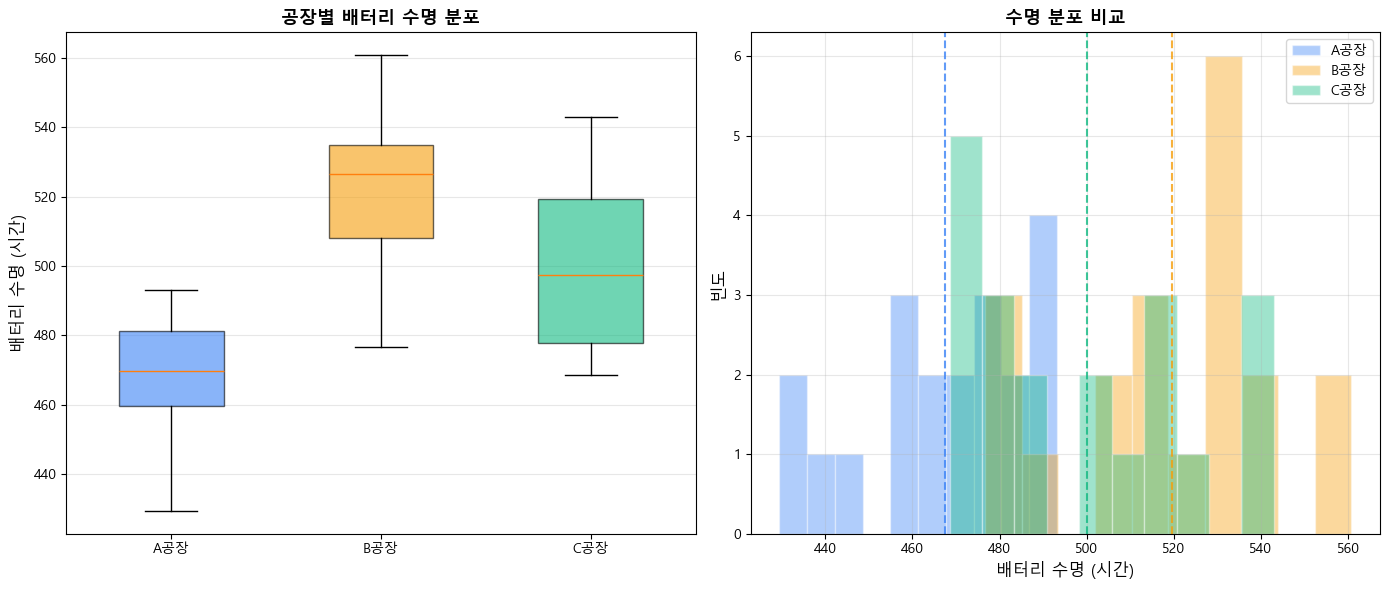

In [4]:
# 분포 시각화: 박스플롯 + 히스토그램
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = ['#3B82F6', '#F59E0B', '#10B981']
bp = axes[0].boxplot([factory_a, factory_b, factory_c],
                    labels=['A공장', 'B공장', 'C공장'],
                    patch_artist=True, widths=0.5)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

axes[0].set_ylabel('배터리 수명 (시간)', fontsize=12)
axes[0].set_title('공장별 배터리 수명 분포', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

for data, name, color in [(factory_a, 'A공장', '#3B82F6'),
                        (factory_b, 'B공장', '#F59E0B'),
                        (factory_c, 'C공장', '#10B981')]:
    axes[1].hist(data, bins=10, alpha=0.4, color=color, edgecolor='white', label=name)
    axes[1].axvline(data.mean(), color=color, linestyle='--', alpha=0.8)

axes[1].set_xlabel('배터리 수명 (시간)', fontsize=12)
axes[1].set_ylabel('빈도', fontsize=12)
axes[1].set_title('수명 분포 비교', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 문제 1-1: 가설 설정 및 가정 검정

**(a)** 분석 목표에 맞는 **귀무가설(H₀)** 과 **대립가설(H₁)** 을 수식으로 설정하세요.

**(b)** 각 공장 데이터의 **정규성 검정**(Shapiro-Wilk)을 수행하세요.

**(c)** 3개 공장의 **Q-Q Plot**을 나란히 그리세요.

**(d)** 정규성이 충족된다면, **등분산 검정**(Levene)을 수행하세요.

**(e)** 가정 검정 결과를 종합하여 **어떤 검정을 사용할지** 결정하세요.
의사결정 과정을 단계별로 설명하세요.

> **의사결정 흐름**: 정규성 확인 → (충족 시) 등분산 확인 → 검정 방법 선택

In [ ]:
print("\n[문제 1-1] 가설 설정 및 가정 검정")
print("-" * 40)

# TODO (a): 가설 설정
print(f'H0 : 공장 별 평균 배터리 수명은 동일하다. mu1 = mu2 = mu3')
print(f'H1 : 적어도 하나의 공장의 배터리 수명 평균이 다르다. Not H0')

# TODO (b): 정규성 검정 (각 공장별)
a_stat, a_pval = stats.shapiro(factory_a)
b_stat, b_pval = stats.shapiro(factory_b)
c_stat, c_pval = stats.shapiro(factory_c)

print(f'a 공정 정규성 검정 p-value : {a_pval}')
print(f'b 공정 정규성 검정 p-value : {b_pval}')
print(f'c 공정 정규성 검정 p-value : {c_pval}')

print('세 집단 모두 유의수준 5% 하에서 귀무가설을 기각할 수 없다.')
print('따라서, 세 집단은 모두 정규 분포를 따른다고 할 수 있다.')


[문제 1-1] 가설 설정 및 가정 검정
----------------------------------------
H0 : 공장의 평균 배터리 수명은 동일하다. mu1 = mu2 = mu3
H1 : 공장의 평균 배터리 수명은 동일하지 않다. Not H0
a 공정 정규성 검정 p-value : 0.10363990852135674
b 공정 정규성 검정 p-value : 0.1745861714279393
c 공정 정규성 검정 p-value : 0.05400965107411224
세 집단 모두 유의수준 5% 하에서 귀무가설을 기각할 수 없다.
따라서, 세 집단은 모두 정규 분포를 따른다고 할 수 있다.


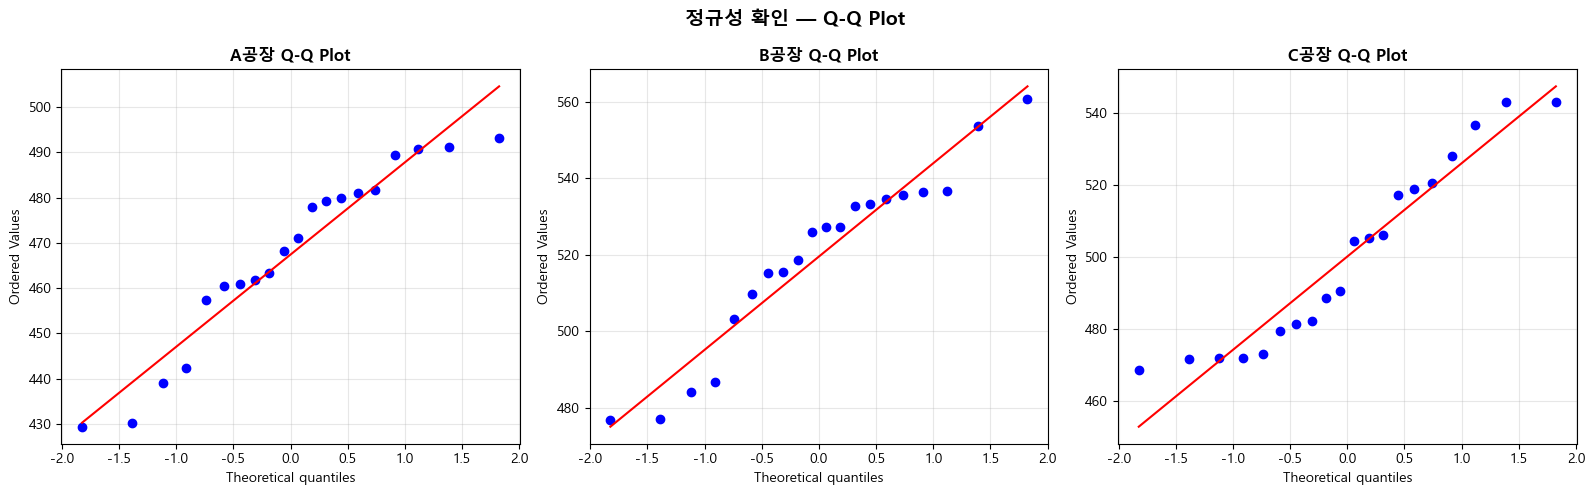

In [9]:
# TODO (c): Q-Q Plot (3개 공장)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("정규성 확인 — Q-Q Plot", fontsize=14, fontweight='bold')

# TODO: 각 공장의 Q-Q Plot 그리기
for ax, data, name, color in [(axes[0], factory_a, 'A공장', '#3B82F6'),
                                (axes[1], factory_b, 'B공장', '#F59E0B'),
                                (axes[2], factory_c, 'C공장', '#10B981')]:
    stats.probplot(data, dist = 'norm', plot = ax)
    ax.set_title(f"{name} Q-Q Plot", fontsize=12, fontweight="bold")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

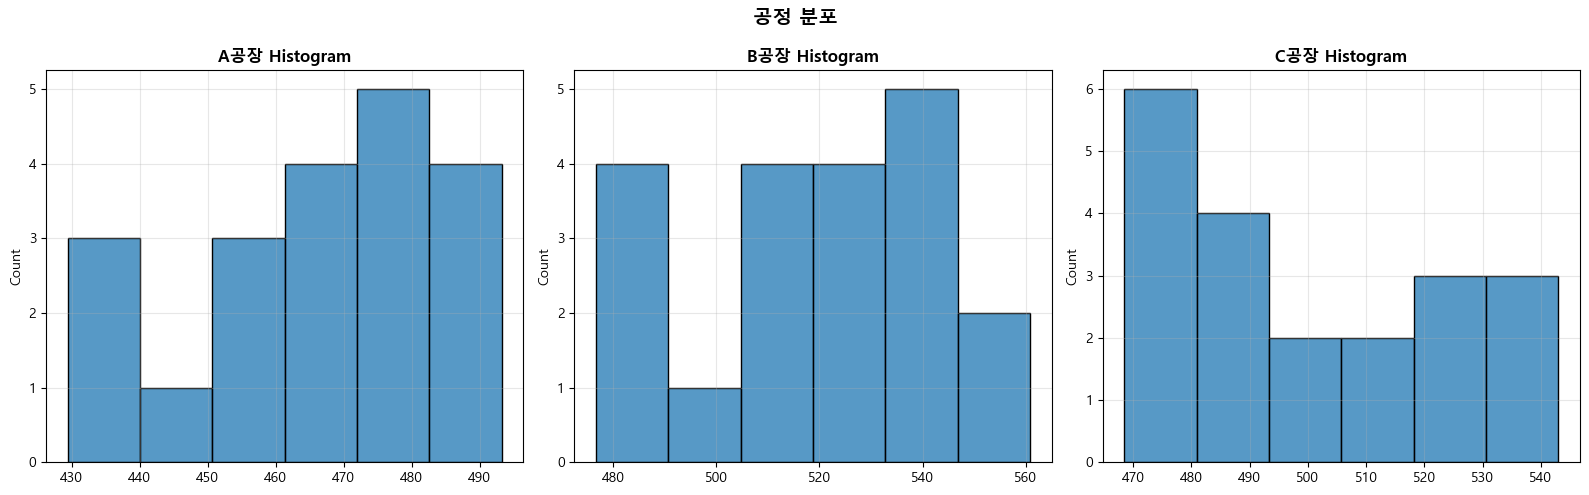

shapiro test 결과 세 공정 모두 정규성을 만족한다는 결론을 얻었지만,
C공장의 p-value와 QQ plot, 분포를 모두 고려했을 때 C공장은 정규성을 만족하지 못 한다고 할 수 있다.
과제인 만큼 anova, kruskal wails 모두 사용해 분석을 진행하고자 한다.


In [13]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("공정 분포", fontsize=14, fontweight='bold')

for ax, data, name, color in [(axes[0], factory_a, 'A공장', '#3B82F6'),
                                (axes[1], factory_b, 'B공장', '#F59E0B'),
                                (axes[2], factory_c, 'C공장', '#10B981')]:
    sns.histplot(data, ax = ax)
    ax.set_title(f"{name} Histogram", fontsize=12, fontweight="bold")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print('shapiro test 결과 세 공정 모두 정규성을 만족한다는 결론을 얻었지만,')
print('C공장의 p-value와 QQ plot, 분포를 모두 고려했을 때 C공장은 정규성을 만족하지 못 한다고 할 수 있다.')
print('과제인 만큼 anova, kruskal wails 모두 사용해 분석을 진행하고자 한다.')

In [15]:
# TODO (d): 등분산 검정 (정규성 충족 시)
lev_stat, lev_pval = stats.levene(factory_a, factory_b, factory_c)
print(f'등분산성의 p-value가 {lev_pval}이므로 유의수준 5%하에서 세 집단의 분산은 동일하다고 할 수 있다.')

# TODO (e): 검정 방법 결정
print('원래대로라면 kruskal wails 검정을 수행해 분석을 진행해야 하지만,')
print('anova, kruskal walis 두 검정 모두 사용해 분석을 진행하고자 한다.')

등분산성의 p-value가 0.35171154787380404이므로 유의수준 5%하에서 세 집단의 분산은 동일하다고 할 수 있다.
원래대로라면 kruskal wails 검정을 수행해 분석을 진행해야 하지만,
anova, kruskal walis 두 검정 모두 사용해 분석을 진행하고자 한다.


### 문제 1-2: ANOVA 검정 수행 및 효과크기

**(a)** 1-1에서 결정한 검정을 수행하세요 (α = 0.05).

**(b)** 전체 효과크기(η² 또는 η²_H)를 계산하고 해석하세요.

**(c)** ω²(오메가제곱)을 계산할 수 있다면 함께 보고하세요.

**(d)** 검정 결과(p-value)와 효과크기를 종합하여 결론을 내리세요.

In [24]:
print("\n[문제 1-2] ANOVA 검정 수행 및 효과크기")
print("-" * 40)

# 표본 데이터 생성
groups = ['A공장'] * 20 + ['B공장'] * 20 + ['C공장'] * 20
lifetimes = np.concatenate([factory_a, factory_b, factory_c])
df_battery = pd.DataFrame({'공장': groups, '수명': lifetimes})

print("배터리 데이터 샘플:")
display(df_battery.sample(5))
print("기술통계:")
display(df_battery.describe().round(2))


[문제 1-2] ANOVA 검정 수행 및 효과크기
----------------------------------------
배터리 데이터 샘플:


,공장,수명
52,C공장,506.1
43,C공장,505.3
32,B공장,486.8
21,B공장,536.4
33,B공장,526.0


기술통계:


,수명
count,60.00
mean,495.69
std,31.50
min,429.40
25%,472.72
50%,490.05
75%,521.88
max,560.80


In [48]:
# 1. ANOVA

# TODO (a): 검정 수행
fac_stat, fac_pval = stats.f_oneway(factory_a, factory_b, factory_c)
print(f'ANOVA 검정의 p-value가 {fac_pval:.9f}로 유의수준 5%하에서 귀무가설을 기각한다.')
print(f'따라서, 공장의 평균 배터리 수명은 적어도 하나가 동일하지 않다고 할 수 있다.')

# TODO (b): 전체 효과크기
aov = pg.anova(dv = '수명', between = '공장', data = df_battery, detailed = True)
print(f'에타 제곱: {aov['np2'].values[0]:.4f}')

# TODO (c): ω² (적절한 검정인 경우)
display(aov)
ss_b = aov['SS'].values[0]
ss_w = aov['SS'].values[1]
df_b = aov['DF'].values[0]
ms_w = aov['MS'].values[1]

ss_t = ss_b + ss_w

omega_sq = (ss_b - df_b * ms_w) / (ss_t + ms_w)
print(f'오메가 제곱 = {omega_sq:.4f}')

# TODO (d): 종합 결론
print('ANOVA 검정 결과 유의수준 5% 하에서 귀무가설을 기각하고, 효과 크기를 보았을 때도 0.45로 효과가 크다고 할 수 있다.')
print('따라서, 공장 별 평균 배터리 수명은 동일하지 않다고 할 수 있다.')

ANOVA 검정의 p-value가 0.000000012로 유의수준 5%하에서 귀무가설을 기각한다.
따라서, 공장의 평균 배터리 수명은 적어도 하나가 동일하지 않다고 할 수 있다.
에타 제곱: 0.4734


,Source,SS,DF,MS,F,p-unc,np2
0,공장,27712.356333,2,13856.178167,25.619021,1.155063e-08,0.473383
1,Within,30828.741000,57,540.855105,NaN,NaN,NaN


오메가 제곱 = 0.4507
ANOVA 검정 결과 유의수준 5% 하에서 귀무가설을 기각하고, 효과 크기를 보았을 때도 0.45로 효과가 크다고 할 수 있다.
따라서, 공장 별 평균 배터리 수명은 동일하지 않다고 할 수 있다.


In [50]:
# 2. Kruskal-Walis

# TODO (a): 검정 수행
krus_stat, krus_pval = stats.kruskal(factory_a, factory_b, factory_c)
print(f'크루스칼-왈리스 검정의 p-value가 {krus_pval:.7f}로 유의수준 5%하에서 귀무가설을 기각한다.')
print(f'따라서, 공장의 평균 배터리 수명은 적어도 하나가 동일하지 않다고 할 수 있다.')

# TODO (b): 전체 효과크기
N3 = len(factory_a) + len(factory_b) + len(factory_c)
eta_sq_h3 = (krus_stat - 3  + 1) / (N3 - 3)
print(f'효과크기 : {eta_sq_h3:.4f}')

# TODO (d): 종합 결론
print('크루스칼 왈리스 검정 결과 유의수준 5% 하에서 귀무가설을 기각하고, 효과 크기를 보았을 때도 0.42로 효과가 크다고 할 수 있다.')
print('따라서, 공장 별 평균 배터리 수명은 적어도 한 공장은 동일하지 않다고 할 수 있다.')

크루스칼-왈리스 검정의 p-value가 0.0000021로 유의수준 5%하에서 귀무가설을 기각한다.
따라서, 공장의 평균 배터리 수명은 적어도 하나가 동일하지 않다고 할 수 있다.
효과크기 : 0.4233
크루스칼 왈리스 검정 결과 유의수준 5% 하에서 귀무가설을 기각하고, 효과 크기를 보았을 때도 0.42로 효과가 크다고 할 수 있다.
따라서, 공장 별 평균 배터리 수명은 적어도 한 공장은 동일하지 않다고 할 수 있다.


### 문제 1-3: 사후검정 — 어떤 공장 쌍이 다른가?

ANOVA가 유의하다면, **"적어도 하나가 다르다"** 는 것만 알 수 있습니다.
**어떤 공장 쌍**이 다른지 확인하려면 사후검정이 필요합니다.

**(a)** 사용한 검정 방법에 맞는 사후검정을 수행하세요.

> | 검정 방법 | 사후검정 |
> |-----------|---------|
> | One-way ANOVA | Tukey HSD |
> | Welch's ANOVA | Games-Howell |
> | Kruskal-Wallis | Dunn 검정 (Bonferroni 보정) |

**(b)** 쌍별 효과크기를 계산하세요.

> - Tukey HSD 후 → Cohen's d (`pg.compute_effsize(x, y, eftype='cohen')`)
> - Games-Howell 후 → Hedges' g (`pg.compute_effsize(x, y, eftype='hedges')`)
> - Dunn 검정 후 → 중앙값 차이로 방향과 크기 해석

**(c)** 사후검정 결과를 종합하여, 구체적으로 어떤 공장이 어떻게 다른지 해석하세요.

**(d)** 공장별 평균 배터리 수명을 막대 그래프(±SEM 오차막대 포함)로 시각화하세요.

In [ ]:
# ANOVA 검정(Tukey HSD)

print("\n[문제 1-3] 사후검정")
print("-" * 40)

# TODO (a): 사후검정 수행
tukey = pairwise_tukeyhsd(df_battery['수명'], df_battery['공장'], alpha = 0.05)
print(tukey)

# TODO (b): 쌍별 효과크기
print('쌍별 효과크기')
print('-' * 30)
group_data = {'A공장':factory_a, 'B공장':factory_b, 'C공장':factory_c}

for (group_name1, group_data1), (group_name2, group_data2) in combinations(group_data.items(), 2):
    d1 = pg.compute_effsize(group_data1, group_data2, eftype = 'cohen')
    d2 = pg.compute_effsize(group_data1, group_data2, eftype = 'hedges')
    size_d1 = '매우 작은' if abs(d1) < 0.2 else '작은' if abs(d1) < 0.5 else '중간' if abs(d1) < 0.8 else '큰'
    print(f'    {group_name1} vs {group_name2}: d1 = {d1:.3f} ({size_d1} 효과)')
    size_d2 = '매우 작은' if abs(d2) < 0.2 else '작은' if abs(d2) < 0.5 else '중간' if abs(d2) < 0.8 else '큰'
    print(f'    {group_name1} vs {group_name2}: d1 = {d2:.3f} ({size_d2} 효과)')

# TODO (c): 종합 해석
print('각 공장 모두 배터리의 차이가 있다고 할 수 있다.')
print('B > C > A 순서로 평균 크기가 나타나고, 효과크기를 고려했을 때')
print('B는 C와 중간 정도의 효과 크기를, A는 C와 효과 크기를 보인다.')


[문제 1-3] 사후검정
----------------------------------------
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
   A공장    B공장   52.085    0.0  34.3875 69.7825   True
   A공장    C공장    32.66 0.0001  14.9625 50.3575   True
   B공장    C공장  -19.425 0.0283 -37.1225 -1.7275   True
-----------------------------------------------------
쌍별 효과크기
------------------------------
    A공장 vs B공장: d1 = -2.367 (큰 효과)
    A공장 vs B공장: d1 = -2.320 (큰 효과)
    A공장 vs C공장: d1 = -1.423 (큰 효과)
    A공장 vs C공장: d1 = -1.395 (큰 효과)
    B공장 vs C공장: d1 = 0.785 (중간 효과)
    B공장 vs C공장: d1 = 0.770 (중간 효과)
각 공장 모두 배터리의 차이가 있다고 할 수 있다.
B < C < A 순서로 평균 크기가 나타나고, 효과크기를 고려했을 때
B는 C와 중간 정도의 효과 크기를, A는 C와 효과 크기를 보인다.


In [58]:
# 크루스칼 왈리스 검정(Dunn)

print("\n[문제 1-3] 사후검정")
print("-" * 40)

# TODO (a): 사후검정 수행
if krus_pval is not None and krus_pval < 0.05:
    print(f'Dunn 사후검정 (Bonferroni 보정)')
    print('=' * 50)

    groups3 = ['A공장'] * 20 + ['B공장'] * 20 + ['C공장'] * 20
    battery3 = np.concatenate([factory_a, factory_b, factory_c])

    dunn3 = sp.posthoc_dunn(df_battery, val_col = '수명', group_col = '공장', p_adjust='bonferroni')
    display(dunn3)

    # TODO (b): 쌍별 효과크기
    group_names = dunn3.columns.tolist()
    medians = {name : np.median(data) for name, data in [('A공장', factory_a), ('B공장', factory_b), ('C공장', factory_c)]}

    for i in range(len(group_names)):
        for j in range(i + 1, len(group_names)):
            g1, g2 = group_names[i], group_names[j]
            p_val = dunn3.iloc[i,j]
            sig = "유의한 차이" if p_val < 0.05 else "유의하지 않음"

            # 비모수 검정이므로 중앙값 방향 해석
            m1, m2 = medians[g1], medians[g2]
            if m1 > m2:
                direction = f"{g1}의 중앙값({m1:.0f})이 {g2}({m2:.0f})보다 높습니다"
            elif m1 < m2:
                direction = f"{g2}의 중앙값({m2:.0f})이 {g1}({m1:.0f})보다 높습니다"
            else:
                direction = f"두 집단의 중앙값이 동일합니다 ({m1:.0f})"

            print(f"  {g1} vs {g2}: {sig} (p={p_val:.4f})")
            print(f"    → {direction}")

    # TODO (c): 종합 해석
    print('A와 B, C공정에 비해 중앙값이 높다고 할 수 있다.')
    print('B >= C > A 순서로 중앙값 크기가 나타난다.')
    print('B 공장이 다른 공장에 비해 배터리 수명이 높다고 할 수 있고, A와 C는 비슷한 수준이다.')


[문제 1-3] 사후검정
----------------------------------------
Dunn 사후검정 (Bonferroni 보정)


,A공장,B공장,C공장
A공장,1.000000,0.000001,0.003804
B공장,0.000001,1.000000,0.204299
C공장,0.003804,0.204299,1.000000


  A공장 vs B공장: 유의한 차이 (p=0.0000)
    → B공장의 중앙값(527)이 A공장(470)보다 높습니다
  A공장 vs C공장: 유의한 차이 (p=0.0038)
    → C공장의 중앙값(498)이 A공장(470)보다 높습니다
  B공장 vs C공장: 유의하지 않음 (p=0.2043)
    → B공장의 중앙값(527)이 C공장(498)보다 높습니다
A와 B, C공정에 비해 중앙값이 높다고 할 수 있다.
B >= C > A 순서로 중앙값 크기가 나타난다.
B 공장이 다른 공장에 비해 배터리 수명이 높다고 할 수 있고, A와 C는 비슷한 수준이다.


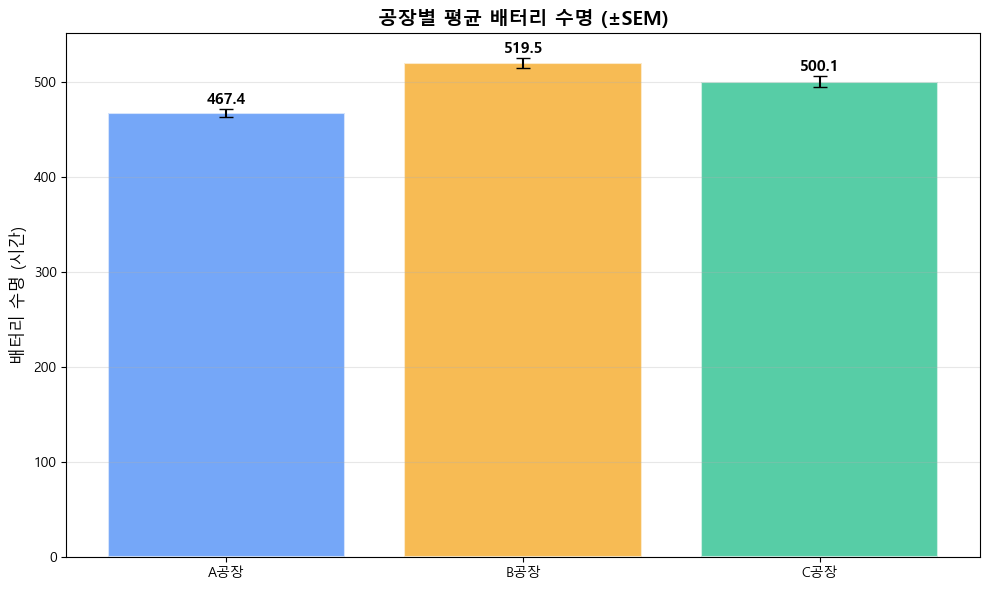

In [41]:
# TODO (d): 막대 그래프 (±SEM)
fig, ax = plt.subplots(figsize=(10, 6))

means = [d.mean() for d in group_data.values()]
sems = [d.std(ddof=1) / np.sqrt(len(d)) for d in group_data.values()]

# TODO: 막대 그래프 + 오차막대 + 평균값 텍스트 표시
bars = ax.bar(group_data.keys(), means, yerr=sems, capsize=5,
            color=colors, alpha=0.7, edgecolor='white', linewidth=1.5)
for bar, mean, sem in zip(bars, means, sems):
    ax.text(bar.get_x() + bar.get_width()/2., mean + sem + 1,
            f'{mean:.1f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('배터리 수명 (시간)', fontsize=12)
ax.set_title('공장별 평균 배터리 수명 (±SEM)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---

## 문제 2: 직원 데이터 상관분석

한 IT 기업에서 직원 30명의 데이터를 수집했습니다.
경력(년), 월급여(만원), 프로젝트 완료 수, 직무 만족도(1~10점)의 관계를 분석합니다.

**분석 목표**:
- 변수 간 상관관계를 파악하고, 어떤 변수 쌍이 유의한 상관을 보이는지 확인합니다.
- Pearson과 Spearman 상관계수를 비교하여 데이터의 특성을 파악합니다.

**주어진 데이터:**

In [59]:
print("\n[문제 2] 직원 데이터 상관분석")
print("=" * 50)

np.random.seed(552)
n_emp = 30

experience = np.round(np.random.uniform(1, 15, n_emp), 1)
salary = np.round(2500 + 180 * experience + np.random.normal(0, 400, n_emp), 0)
projects = np.round(np.clip(2 + 0.8 * experience + np.random.normal(0, 3, n_emp), 0, 30), 0).astype(int)
satisfaction = np.round(np.clip(4 + 0.3 * experience - 0.0005 * salary + np.random.normal(0, 1.8, n_emp), 1, 10), 1)

df_emp = pd.DataFrame({
    '경력(년)': experience,
    '월급여(만원)': salary,
    '프로젝트수': projects,
    '만족도': satisfaction
})
print("직원 데이터 샘플:")
display(df_emp.sample(5))
print("기술통계:")
display(df_emp.describe().round(2))


[문제 2] 직원 데이터 상관분석
직원 데이터 샘플:


,경력(년),월급여(만원),프로젝트수,만족도
23,8.7,4354.0,15,6.3
3,12.2,4357.0,11,6.9
15,8.8,4159.0,11,5.3
24,5.8,2343.0,5,8.6
4,3.8,3216.0,3,4.1


기술통계:


,경력(년),월급여(만원),프로젝트수,만족도
count,30.00,30.00,30.00,30.00
mean,8.69,3973.30,9.03,4.49
std,4.07,871.03,4.86,2.04
min,1.80,2094.00,0.00,1.00
25%,5.72,3248.00,6.00,3.02
50%,8.75,4045.00,8.50,4.05
75%,12.15,4703.50,13.75,6.20
max,14.60,5378.00,19.00,8.60


### 문제 2-1: 산점도와 상관 행렬

**(a)** `경력(년)`과 `월급여(만원)`의 산점도를 그리고, 회귀선을 추가하세요.
시각적으로 어떤 관계가 보이는지 서술하세요.

**(b)** 전체 변수의 **Pearson 상관 행렬**을 계산하고 히트맵으로 시각화하세요.

> `df_emp.corr(method='pearson')` + `seaborn.heatmap()`

**(c)** 전체 변수의 **Spearman 상관 행렬**도 함께 히트맵으로 그려서 나란히 비교하세요.

In [60]:
df_emp.columns

Index(['경력(년)', '월급여(만원)', '프로젝트수', '만족도'], dtype='str')


[문제 2-1] 산점도와 상관 행렬
----------------------------------------


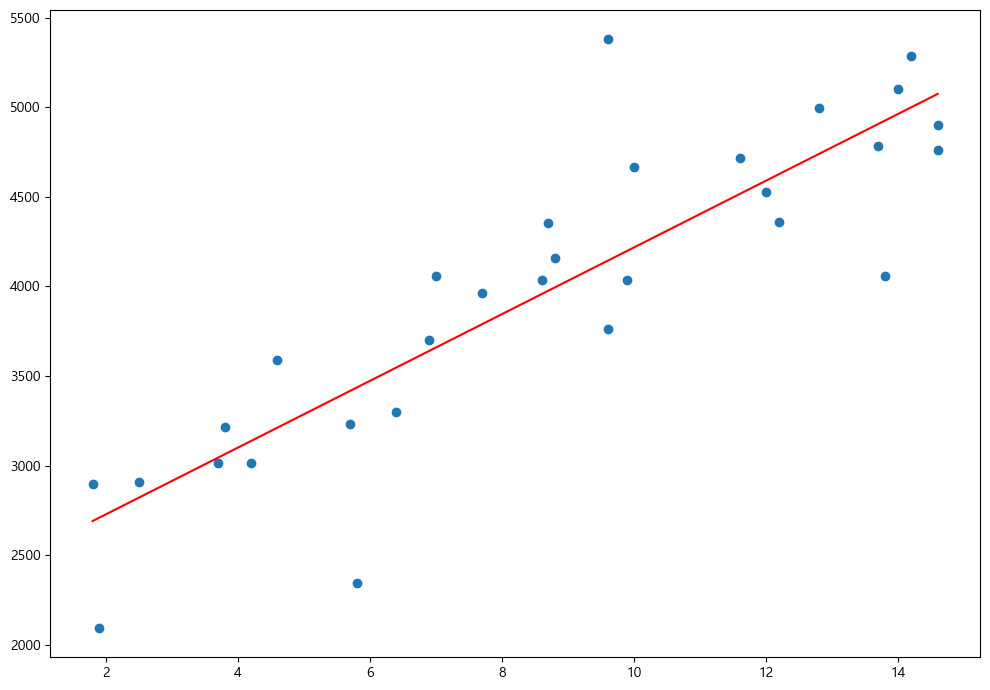

(a) 시각적 관찰 결과 해석:
    산점도와 추세선으로 보았을 때 경력과 월급여는 상관성이 존재하는 걸로 보인다.


In [65]:
print("\n[문제 2-1] 산점도와 상관 행렬")
print("-" * 40)

fig, ax = plt.subplots(figsize = (10,7))

# TODO (a): 경력 vs 월급여 산점도 + 회귀선
ax.scatter(data = df_emp, x = '경력(년)', y = '월급여(만원)')
z = np.polyfit(df_emp['경력(년)'], df_emp['월급여(만원)'],1)
p = np.poly1d(z)
x_line = np.linspace(df_emp['경력(년)'].min(), df_emp['경력(년)'].max())
ax.plot(x_line, p(x_line), color = 'red')

plt.tight_layout()
plt.show()

print("(a) 시각적 관찰 결과 해석:")
print(f"    산점도와 추세선으로 보았을 때 경력과 월급여는 상관성이 존재하는 걸로 보인다.")

<Axes: >

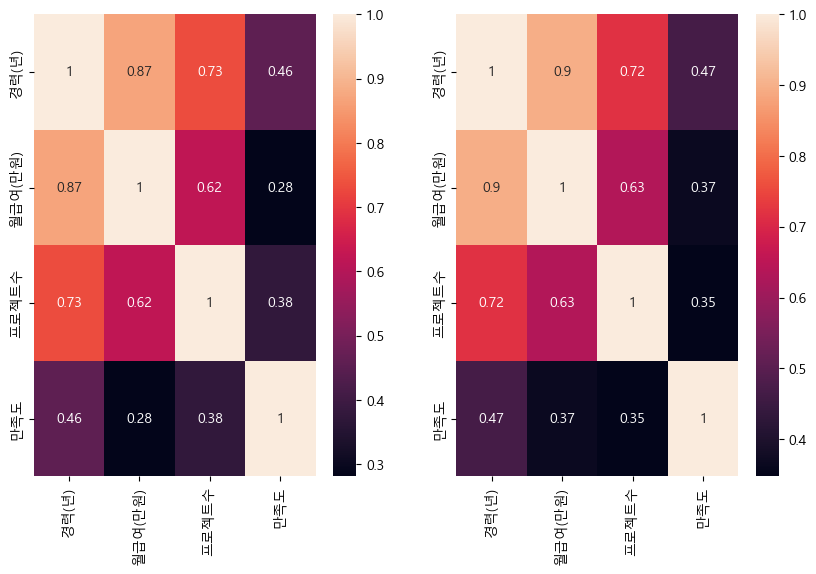

In [71]:
# Pearson vs Spearman 상관 히트맵

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# TODO (b): Pearson 상관 행렬 히트맵
sns.heatmap(df_emp.corr(), annot = True, ax = axes[0])

# TODO (c): Spearman 상관 행렬 히트맵
sns.heatmap(df_emp.corr(method = 'spearman'), annot = True, ax = axes[1])

### 문제 2-2: 상관계수 가설검정

**(a)** `경력(년)`과 `월급여(만원)` 사이의 **Pearson 상관계수**와 **p-value**를 구하세요.

**(b)** 같은 변수 쌍에 대해 **Spearman 상관계수**와 **p-value**를 구하세요.

**(c)** 두 상관계수를 비교하세요. 차이가 크다면/작다면 어떤 의미인지 설명하세요.

In [79]:
print("\n[문제 2-2] 상관계수 가설검정")
print("-" * 40)

# TODO (a): Pearson 상관계수
r, p_val = stats.pearsonr(df_emp['경력(년)'], df_emp['월급여(만원)'])
print('Pearson 상관분석 결과')
print(f'r : {r:.2f}, p_value : {p_val:.2f}')

# TODO (b): Spearman 상관계수
s_result = pg.pairwise_corr(df_emp[['경력(년)','월급여(만원)']], method = 'spearman')
display(s_result)


# TODO (c): 비교
print(f"\n(c) Pearson vs Spearman 비교:")
print(f"    차이와 해석: Pearson의 상관계수가 {r:.2f}, Spearman의 상관계수가 {s_result['r'].values[0]:.2f}로 측정되어")
print(f'    경력과 월급여는 선형에 가까운 강한 상관관계를 가진다.')


[문제 2-2] 상관계수 가설검정
----------------------------------------
Pearson 상관분석 결과
r : 0.87, p_value : 0.00


,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,경력(년),월급여(만원),spearman,two-sided,30,0.896529,"[0.79, 0.95]",2.076629e-11,1.0



(c) Pearson vs Spearman 비교:
    차이와 해석: Pearson의 상관계수가 0.87, Spearman의 상관계수가 0.90로 측정되어
    경력과 월급여는 선형에 가까운 강한 상관관계를 가진다.


### 문제 2-3: 다변량 상관분석과 해석

**(a)** `pg.pairwise_corr(df_emp, method='pearson')`으로 모든 변수 쌍의 상관분석을 수행하세요.
유의한 상관(p < 0.05)을 보이는 쌍을 모두 찾으세요.

**(b)** 유의한 상관을 보이는 변수 쌍 중에서, **상관이 인과를 의미하지 않는** 예시를 하나 들고,
왜 인과라고 할 수 없는지 교란변수의 가능성을 포함하여 설명하세요.

> **상관 vs 인과**: 두 변수가 함께 움직여도(상관), 한 변수가 다른 변수를 변화시킨다(인과)고
> 단정할 수 없습니다. 인과를 확인하려면 **실험(RCT, A/B 테스트)** 이 필요합니다.

**(c)** 만약 `경력`과 `만족도` 사이에 유의한 상관이 있다면,
"경력이 많을수록 만족도가 높다"고 결론 내릴 수 있나요?
왜 그런지/아닌지 교란변수(예: 직급, 급여, 업무 환경)의 관점에서 논의하세요.

In [83]:
print("\n[문제 2-3] 다변량 상관분석과 해석")
print("-" * 40)

# TODO (a): pairwise_corr
pearson_result = pg.pairwise_corr(df_emp, method = 'pearson')
pearson_result = pearson_result[pearson_result['p-unc'] < 0.05]
display(pearson_result)

# TODO (b): 상관 vs 인과 — 교란변수 논의
print('급여와 프로젝트 수는 상관성이 높지만, 그것보다는 경력 때문에 자연스럽게 올라가 두 관계가 상관성이 있는 것으로 보일 수 있다.')

# TODO (c): 경력 vs 만족도 해석
print('경력 증가로 급여가 올라 만족도가 올랐을 가능성이 존재하기 때문에 급여가 교란 변수일 가능성이 있다.')
print('따라서, 경력이 많을 수록 만족도가 높다고 할 수 없다.')


[문제 2-3] 다변량 상관분석과 해석
----------------------------------------


,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,경력(년),월급여(만원),pearson,two-sided,30,0.870138,"[0.74, 0.94]",4.220485e-10,2.496e+07,1.000000
1,경력(년),프로젝트수,pearson,two-sided,30,0.731927,"[0.5, 0.86]",4.297150e-06,5280.265,0.998403
2,경력(년),만족도,pearson,two-sided,30,0.456776,"[0.12, 0.7]",1.116697e-02,4.899,0.738737
3,월급여(만원),프로젝트수,pearson,two-sided,30,0.620774,"[0.34, 0.8]",2.520477e-04,134.422,0.968911
5,프로젝트수,만족도,pearson,two-sided,30,0.376189,"[0.02, 0.65]",4.047426e-02,1.683,0.549764


급여와 프로젝트 수는 상관성이 높지만, 그것보다는 경력 때문에 자연스럽게 올라가 두 관계가 상관성이 있는 것으로 보일 수 있다.
경력 증가로 급여가 올라 만족도가 올랐을 가능성이 존재하기 때문에 급여가 교란 변수일 가능성이 있다.
따라서, 경력이 많을 수록 만족도가 높다고 할 수 없다.


---

## 문제 3: 앱 UI 변경 A/B 테스트 (전환율 비교)

모바일 쇼핑 앱에서 결제 화면 UI를 개선하면 **구매 전환율**이 높아지는지 A/B 테스트를 수행합니다.

- **대조군(A)**: 기존 결제 화면
- **실험군(B)**: 개선된 결제 화면 (버튼 크기 확대 + 단계 축소)
- **지표**: 구매 전환율 (결제 완료 비율)
- **현재 전환율**: 8%
- **비즈니스 목표**: 최소 2%p 이상 개선을 탐지하고 싶음 (8% → 10%)

**분석 목표**: 개선된 UI가 기존 대비 전환율을 유의하게 높이는지 검정합니다.

---

### 문제 3-1: 실험 설계 — 표본 크기 산정

A/B 테스트를 실행하기 **전에** 필요한 표본 크기를 산정합니다.

**(a)** 실험 설계 파라미터를 정리하세요.

**(b)** **효과크기(Cohen's h)** 를 계산하세요.

**(c)** **집단당 필요 표본 크기**를 산정하세요.

**(d)** 양측검정과 단측검정 각각에 대해 표본 크기를 구하고, 차이를 비교하세요.
이 실험에서는 어떤 검정이 더 적절한지 근거와 함께 설명하세요.

In [90]:
print("\n[문제 3] 앱 UI 변경 A/B 테스트")
print("=" * 50)
print("\n[문제 3-1] 실험 설계 — 표본 크기 산정")
print("-" * 40)

baseline_rate = 0.08   # 기존 전환율
mde = 0.02             # 최소 탐지 효과 (2%p)
alpha = 0.05           # 유의수준
power_target = 0.80    # 검정력

# TODO (a): 파라미터 정리
print('실험 설계 (단측 검정)')
print('-' * 40)
print(f'기존 전환율 p0 : {baseline_rate:.0%}')
print(f'목표 전환율 p1 : {baseline_rate + mde:.0%}')
print(f'MDE (최소 탐지 효과): {mde:.0%}')
print(f'유의수준 : {alpha}')
print(f'검정력 : {power_target}')

# TODO (b): 효과크기 (Cohen's h)
effect_size = abs(proportion_effectsize(baseline_rate + mde, baseline_rate))

# TODO (c): 필요 표본 크기
power_analysis = NormalIndPower()
sample_size_larger = power_analysis.solve_power(
    effect_size = effect_size,
    alpha = alpha,
    power = power_target,
    alternative = 'larger'
)
sample_size_larger = int(np.ceil(sample_size_larger))

# TODO (d): 양측 vs 단측 비교 및 선택
sample_size_two_sided = power_analysis.solve_power(
    effect_size = effect_size,
    alpha = alpha,
    power = power_target,
    alternative = 'two-sided'
)
sample_size_two_sided = int(np.ceil(sample_size_two_sided))

print(f'양측 검정에 필요한 표본 : {sample_size_two_sided * 2}')
print(f'단측 검정에 필요한 표본 : {sample_size_larger * 2}')
print(f'현재 실험 설계 상 전환율 개선을 하고자 하기 때문에, 양측 검정보다는 단측 검정이 더 가설을 검정하기에 적합하다.')


[문제 3] 앱 UI 변경 A/B 테스트

[문제 3-1] 실험 설계 — 표본 크기 산정
----------------------------------------
실험 설계 (단측 검정)
----------------------------------------
기존 전환율 p0 : 8%
목표 전환율 p1 : 10%
MDE (최소 탐지 효과): 2%
유의수준 : 0.05
검정력 : 0.8
양측 검정에 필요한 표본 : 6410
단측 검정에 필요한 표본 : 5050
현재 실험 설계 상 전환율 개선을 하고자 하기 때문에, 양측 검정보다는 단측 검정이 더 가설을 검정하기에 적합하다.


### 문제 3-2: A/B 테스트 실행 및 검정

실험을 진행하여 아래 데이터를 수집했습니다.

**(a)** 각 집단의 전환율을 계산하세요.

**(b)** **z-비율검정**을 수행하세요.

> `proportions_ztest(count, nobs, alternative=...)`

**(c)** **효과크기(Cohen's h)** 를 관측된 전환율로 계산하세요.

**(d)** 각 집단의 **95% 신뢰구간**을 구하세요.

> `proportion_confint(count, nobs, alpha=0.05, method='wilson')`

**(e)** **비율 차이의 95% 신뢰구간**을 구하세요.

> `confint_proportions_2indep(count1, nobs1, count2, nobs2, method='wald')`

**(f)** **상대적 개선율(Relative Lift)** 을 계산하세요.

> 상대적 개선율 = (실험군 전환율 − 대조군 전환율) / 대조군 전환율 × 100

**(g)** 전환율 비교 막대 그래프를 그리세요 (95% 신뢰구간 포함).

In [109]:
print("\n[문제 3-2] A/B 테스트 실행 및 검정")
print("-" * 40)

np.random.seed(553)
n_per_group = 2600  # 실험에 참여한 인원 (집단당)

# 데이터 생성 (시뮬레이션)
control_conv = np.random.binomial(1, 0.08, n_per_group)    # 대조군: 8%
treatment_conv = np.random.binomial(1, 0.105, n_per_group)  # 실험군: 10.5%

# TODO (a): 전환율 계산
cnt = np.array([treatment_conv.sum(), control_conv.sum()])
nobs = np.array([n_per_group, n_per_group])

print(f'대조군 전환율 : {cnt[1] / nobs[1]:.4f}')
print(f'실험군 전환율 : {cnt[0] / nobs[0]:.4f}')
print(f'실험군, 대조군 전환율 차이 : {cnt[0] / nobs[0] - cnt[1] / nobs[1]:.4f}')

# TODO (b): z-비율검정
z_stat, z_p = proportions_ztest(cnt, nobs, alternative = 'larger')
print(f'검정 결과 p-value가 {z_p:.4f}으로 유의수준 5%하에서 귀무가설을 기각한다.')
print(f'따라서, 화면을 개선한 전환율이 기존보다 크다고 할 수 있다.')

# TODO (c): 관측된 효과크기 (Cohen's h)
h = proportion_effectsize(cnt[1] / nobs[1], cnt[0] / nobs[0])
print(f'효과크기가 {abs(h):.2f}로 작은 효과를 보인다.')

# TODO (d): 실험군, 대조군 95% 신뢰구간
ci_c = proportion_confint(control_conv.sum(), n_per_group, alpha = 0.05, method = 'wilson')
ci_t = proportion_confint(treatment_conv.sum(), n_per_group, alpha = 0.05, method = 'wilson')
print(f'대조군 전환율 95% 신뢰구간 : [{ci_c[0]:.4f}, {ci_c[1]:.4f}]')
print(f'실험군 전환율 95% 신뢰구간 : [{ci_t[0]:.4f}, {ci_t[1]:.4f}]')

# TODO (e): 비율 차이의 95% 신뢰구간
ci_low, ci_upp = confint_proportions_2indep(
    cnt[0], nobs[0],
    cnt[1], nobs[1],
    method = 'wald'
)
print(f'비율 차이의 95% 신뢰구간 : [{ci_low:.4f}, {ci_upp:.4f}]')

# TODO (f): 상대적 개선율
relative_lift = (cnt[0]/nobs[0] - cnt[1]/nobs[1]) / (cnt[1]/nobs[1]) * 100
print(f'    상대적 개선율: {relative_lift:+.1f}%')


[문제 3-2] A/B 테스트 실행 및 검정
----------------------------------------
대조군 전환율 : 0.0831
실험군 전환율 : 0.1112
실험군, 대조군 전환율 차이 : 0.0281
검정 결과 p-value가 0.0003으로 유의수준 5%하에서 귀무가설을 기각한다.
따라서, 화면을 개선한 전환율이 기존보다 크다고 할 수 있다.
효과크기가 0.10로 작은 효과를 보인다.
대조군 전환율 95% 신뢰구간 : [0.0731, 0.0943]
실험군 전환율 95% 신뢰구간 : [0.0996, 0.1238]
비율 차이의 95% 신뢰구간 : [0.0120, 0.0442]
    상대적 개선율: +33.8%


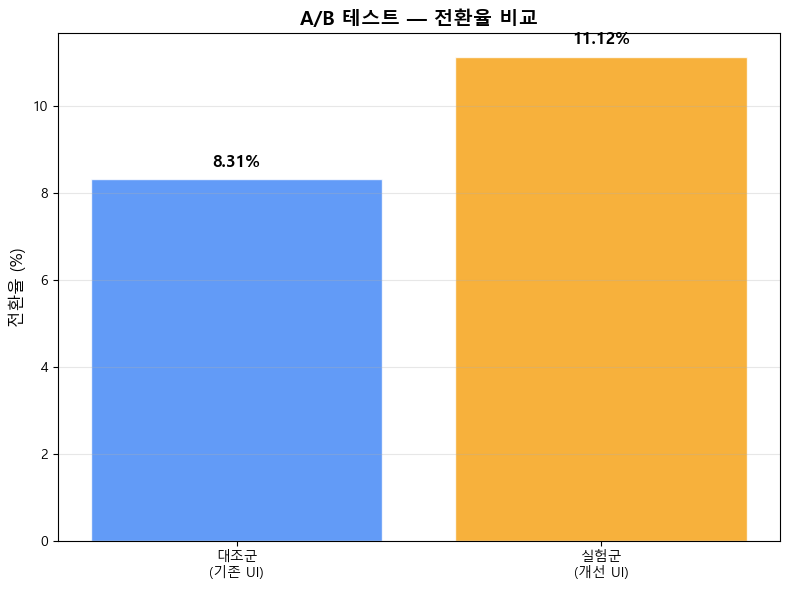

In [111]:
# TODO (g): 전환율 비교 막대 그래프 (신뢰구간 포함)
fig, ax = plt.subplots(figsize=(8, 6))

control_rate = cnt[1] / nobs[1]
treatment_rate = cnt[0] / nobs[0]

# TODO: 막대 그래프 그리기
labels = ['대조군\n(기존 UI)', '실험군\n(개선 UI)']
rates = [control_rate * 100, treatment_rate * 100]
bar_colors = ['#3B82F6', '#F59E0B']
bars = ax.bar(labels, rates, color=bar_colors, alpha=0.8, edgecolor='white')

for bar, rate in zip(bars, rates):
    ax.text(bar.get_x() + bar.get_width() / 2., rate + 0.2,
            f'{rate:.2f}%', ha = 'center', va = 'bottom', fontsize = 12, fontweight = 'bold')

ax.set_ylabel('전환율 (%)', fontsize=12)
ax.set_title('A/B 테스트 — 전환율 비교', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 문제 3-3: 비즈니스 의사결정

**(a)** A/B 테스트 결과를 종합하여, UI 변경을 **전체 사용자에게 적용할지** 의사결정을 내리세요.
아래 항목을 모두 포함하여 보고서 형식으로 작성하세요.

> | 항목 | 내용 |
> |------|------|
> | 통계적 유의성 | p-value와 유의수준 비교 |
> | 효과크기 | Cohen's h와 해석 |
> | 실무적 의미 | 상대적 개선율과 비즈니스 임팩트 |
> | 신뢰구간 | 비율 차이의 신뢰구간과 두 집단의 신뢰구간 겹침 여부 |
> | 최종 권고 | 적용 / 미적용 / 추가 실험 필요 |

**(b)** 만약 p-value는 유의하지만 효과크기가 매우 작다면(예: Cohen's h < 0.1),
어떤 의사결정이 적절한지 설명하세요.

In [116]:
print("\n[문제 3-3] 비즈니스 의사결정")
print("-" * 40)

# TODO (a): 종합 보고서
print("(a) A/B 테스트 결과 보고서:")
print(f"    [통계적 유의성] p-value가 {z_p:.4f}로 귀무가설을 기각한다.")
print(f"    [효과크기] {h:.4f}로 작은 효과크기를 보인다.")
print(f"    [실무적 의미] 상대적 개선율이 {relative_lift:+.1f}%이다.")
print(f"    비즈니스 임팩트는 하루 방문 유저수와 그에 따른 매출 정보가 있다면,")
print(f'    상대적 개선율을 통해 직관적인 수익 정도를 계산할 수 있다.')
print(f"    [신뢰구간] 비율 차이의 신뢰구간이 0을 포함하지 않고, 두 집단의 신뢰구간이 겹치지 않는다.")
print(f"    [최종 권고] 통계적으로 유의한 차이를 보이지만, 효과크기가 작기 때문에 표본의 크기가 상대적으로 커 일어난 차이일 것으로 예상된다.")

# TODO (b): 유의하지만 효과 작은 경우
print(f"\n(b) p 유의 + 효과크기 작은 경우의 의사결정:")
print(f"    통계적으로 유의한 차이를 보이지만, 효과크기가 작기 때문에 표본의 크기가 상대적으로 커 일어난 차이일 것으로 예상된다.")


[문제 3-3] 비즈니스 의사결정
----------------------------------------
(a) A/B 테스트 결과 보고서:
    [통계적 유의성] p-value가 0.0003로 귀무가설을 기각한다.
    [효과크기] -0.0951로 작은 효과크기를 보인다.
    [실무적 의미] 상대적 개선율이 +33.8%이다.
    비즈니스 임팩트는 하루 방문 유저수와 그에 따른 매출 정보가 있다면,
    상대적 개선율을 통해 직관적인 수익 정도를 계산할 수 있다.
    [신뢰구간] 비율 차이의 신뢰구간이 0을 포함하지 않고, 두 집단의 신뢰구간이 겹치지 않는다.
    [최종 권고] 통계적으로 유의한 차이를 보이지만, 효과크기가 작기 때문에 표본의 크기가 상대적으로 커 일어난 차이일 것으로 예상된다.

(b) p 유의 + 효과크기 작은 경우의 의사결정:
    통계적으로 유의한 차이를 보이지만, 효과크기가 작기 때문에 표본의 크기가 상대적으로 커 일어난 차이일 것으로 예상된다.


---

## 문제 4: 학습 앱 A/B 테스트 (연속형 지표 — 학습 시간 비교)

온라인 학습 앱에서 새로운 **게이미피케이션 기능**(배지, 레벨업 시스템)을 도입하면
일일 학습 시간이 늘어나는지 A/B 테스트를 진행합니다.

- **대조군(A)**: 기존 앱 (게이미피케이션 없음)
- **실험군(B)**: 게이미피케이션 도입 버전
- **지표**: 일일 학습 시간 (분)

**분석 목표**: 게이미피케이션 도입이 일일 학습 시간을 유의하게 증가시키는지 검정합니다.

**주어진 데이터:**

In [117]:
print("\n[문제 4] 학습 앱 A/B 테스트 — 학습 시간 비교")
print("=" * 50)

np.random.seed(554)
n_ab = 300

# 학습 시간 데이터 (지수분포 — 우측 꼬리가 긴 비대칭 분포)
time_control = np.round(np.random.exponential(scale=25, size=n_ab), 1)    # 대조군: 평균 25분
time_treatment = np.round(np.random.exponential(scale=30, size=n_ab), 1)  # 실험군: 평균 30분

print(f"  대조군 (n={n_ab}): 평균={time_control.mean():.1f}분, 중앙값={np.median(time_control):.1f}분, SD={time_control.std(ddof=1):.1f}분")
print(f"  실험군 (n={n_ab}): 평균={time_treatment.mean():.1f}분, 중앙값={np.median(time_treatment):.1f}분, SD={time_treatment.std(ddof=1):.1f}분")


[문제 4] 학습 앱 A/B 테스트 — 학습 시간 비교
  대조군 (n=300): 평균=25.8분, 중앙값=18.6분, SD=25.2분
  실험군 (n=300): 평균=27.7분, 중앙값=22.6분, SD=24.1분


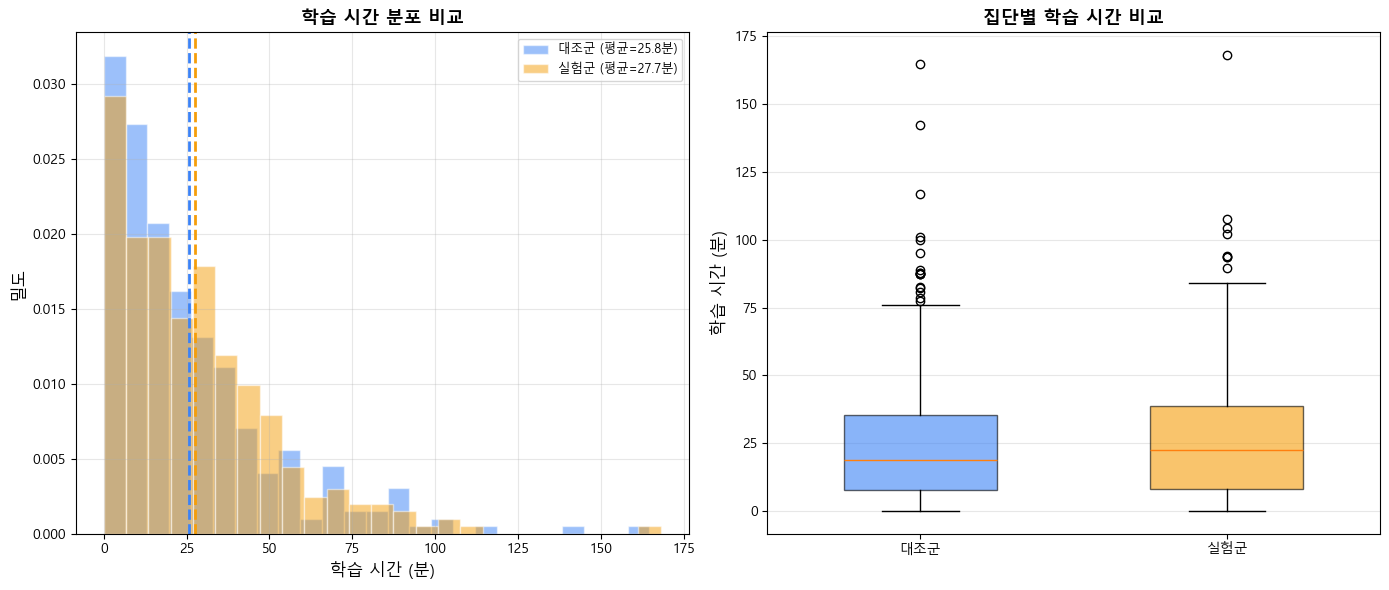

In [118]:
# 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].hist(time_control, bins=25, alpha=0.5, color='#3B82F6', edgecolor='white',
            label=f'대조군 (평균={time_control.mean():.1f}분)', density=True)
axes[0].hist(time_treatment, bins=25, alpha=0.5, color='#F59E0B', edgecolor='white',
            label=f'실험군 (평균={time_treatment.mean():.1f}분)', density=True)
axes[0].axvline(time_control.mean(), color='#3B82F6', linestyle='--', linewidth=2)
axes[0].axvline(time_treatment.mean(), color='#F59E0B', linestyle='--', linewidth=2)
axes[0].set_xlabel('학습 시간 (분)', fontsize=12)
axes[0].set_ylabel('밀도', fontsize=12)
axes[0].set_title('학습 시간 분포 비교', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(alpha=0.3)

bp = axes[1].boxplot([time_control, time_treatment],
                    labels=['대조군', '실험군'],
                    patch_artist=True, widths=0.5)
bp['boxes'][0].set_facecolor('#3B82F6')
bp['boxes'][0].set_alpha(0.6)
bp['boxes'][1].set_facecolor('#F59E0B')
bp['boxes'][1].set_alpha(0.6)
axes[1].set_ylabel('학습 시간 (분)', fontsize=12)
axes[1].set_title('집단별 학습 시간 비교', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 문제 4-1: 정규성 확인과 검정 방법 결정

**(a)** 각 집단의 **정규성 검정**(Shapiro-Wilk)을 수행하세요.

**(b)** 분포의 **왜도(skewness)** 를 계산하세요.

> `from scipy.stats import skew` → `skew(data)`

**(c)** 이 데이터에 t-검정을 적용할 수 있는지 판단하세요.
**중심극한정리(CLT)** 의 관점에서, 표본 크기(n=300)와 왜도를 함께 고려하여 설명하세요.

> | \|skew\| | 분류 | CLT 실무 기준 |
> |:--------:|:---:|:-------------|
> | < 0.5 | 거의 대칭 | n ≥ 15~20이면 충분 |
> | 0.5 ~ 1.0 | 중간 비대칭 | n ≥ 30 권장 |
> | > 1.0 | 강한 비대칭 | n ≥ 100+ 또는 비모수 고려 |

**(d)** 이 데이터에 사용할 **검정 방법**을 결정하세요.
모수 검정(Welch's t)과 비모수 검정(Mann-Whitney U) 중 어떤 것이 적절한지,
또는 **둘 다 수행하여 비교**하는 것이 좋은지 근거를 제시하세요.

In [127]:
print("\n[문제 4-1] 정규성 확인과 검정 방법 결정")
print("-" * 40)

# TODO (a): 정규성 검정
z_stat1, p_val1 = stats.shapiro(time_treatment)
z_stat2, p_val2 = stats.shapiro(time_control)

print(f'실험군 정규성 검정 결과 p-value가 {p_val1:.4f}으로 정규성을 따르지 않는다.')
print(f'대조군 정규성 검정 결과 p-value가 {p_val2:.4f}으로 정규성을 따르지 않는다.')

# TODO (b): 왜도
treat_skew = skew(time_treatment)
cont_skew = skew(time_control)

print(f'실험군 왜도가 {treat_skew:.4f}으로 오른쪽 꼬리가 긴 분포를 보인다..')
print(f'대조군 왜도가 {cont_skew:.4f}으로 오른쪽 꼬리가 긴 분포를 보인다.')

# TODO (c): CLT 판단
print(f'정규성을 만족하지 않고, 데이터의 분포가 많이 치우쳐진 형태이다.')
print(f'하지만, 대표본(n = 300)으로 표본 평균의 분포가 CLT에 의해 정규분포를 따르기 때문에,')
print(f'모수적 방법인 Welth\'s를 사용하되, 비모수 검정인 Mann-Whitney도 수행해 결과를 비교해야 한다.')

# TODO (d): 검정 방법 결정
print('Welth\'s t를 수행하고 Mann-Whitney를 참고용 결과로 함께 활용한다.')


[문제 4-1] 정규성 확인과 검정 방법 결정
----------------------------------------
실험군 정규성 검정 결과 p-value가 0.0000으로 정규성을 따르지 않는다.
대조군 정규성 검정 결과 p-value가 0.0000으로 정규성을 따르지 않는다.
실험군 왜도가 1.5407으로 오른쪽 꼬리가 긴 분포를 보인다..
대조군 왜도가 1.8458으로 오른쪽 꼬리가 긴 분포를 보인다.
정규성을 만족하지 않고, 데이터의 분포가 많이 치우쳐진 형태이다.
하지만, 대표본(n = 300)으로 표본 평균의 분포가 CLT에 의해 정규분포를 따르기 때문에,
모수적 방법인 Welth's를 사용하되, 비모수 검정인 Mann-Whitney도 수행해 결과를 비교해야 한다.
Welth's t를 수행하고 Mann-Whitney를 참고용 결과로 함께 활용한다.


### 문제 4-2: 검정 수행 및 효과크기

**(a)** **Welch's t-검정**을 수행하세요 (pingouin의 `pg.ttest()` 사용).

> `pg.ttest(x, y, alternative='two-sided')` → T, p-val, cohen-d, CI95%, BF10, power 제공

**(b)** **Mann-Whitney U 검정**을 수행하세요 (pingouin의 `pg.mwu()` 사용).

> `pg.mwu(x, y, alternative='two-sided')` → U-val, p-val, RBC, CLES 제공

**(c)** 두 검정의 결과를 비교하세요. 결론이 같은가요, 다른가요?
왜 같은/다른 결론이 나오는지 데이터의 특성(분포, 표본 크기)과 연결하여 설명하세요.

**(d)** 검정 결과를 종합하여, 게이미피케이션 도입의 효과에 대한 최종 결론을 내리세요.
통계적 유의성, 효과크기, 상대적 개선율을 모두 포함하세요.

In [ ]:
print("\n[문제 4-2] 검정 수행 및 효과크기")
print("-" * 40)

# TODO (a): Welch's t-검정 (pingouin) -> 왜 two-sided?
ttest_result = pg.ttest(time_treatment, time_control, alternative = 'two-sided')

# TODO (b): Mann-Whitney U 검정 (pingouin)
mwu_result = pg.mwu(time_treatment, time_control, alternative = 'two-sided')

# TODO (c): 두 검정 비교
print(f't test 검정 결과 : {ttest_result['p-val'].values[0]:.4f}로 귀무가설을 기각할 수 없다.')
print(f'mwu 검정 결과 : {mwu_result['p-val'].values[0]:.4f}로 귀무가설을 기각할 수 없다.')

# 효과크기
print(f'ttest 효과 크기 : {ttest_result['cohen-d'].values[0]:.4f}')
print(f'mwu 효과 크기 : {mwu_result['RBC'].values[0]:.4f}')

# TODO (d): 최종 결론
print(f'두 검정 모두 귀무가설을 기각할 수 없고, 효과크기 역시 작기 때문에')
print(f'게이미피케이션 도입을 하더라도 일일 학습 시간의 평균에는 차이가 없다고 할 수 있다.')


[문제 4-2] 검정 수행 및 효과크기
----------------------------------------
t test 검정 결과 : 0.3583로 귀무가설을 기각할 수 없다.
mwu 검정 결과 : 0.1461로 귀무가설을 기각할 수 없다.
ttest 효과 크기 : 0.0751
mwu 효과 크기 : 0.0686
두 검정 모두 귀무가설을 기각할 수 없고, 효과크기 역시 작기 때문에
게이미피케이션 도입을 하더라도 일일 학습 시간의 평균에는 차이가 없다고 할 수 있다.
